# Feature importance and selection

In this project I first go through strategies for feature importance and selection working directly from the data and working based on models. Then I visualize the feature importances and compare different strategies. Finally I implement an automatic feature selection algorithm, and esitimate the variance and empirical p-values for feature importances.

Before starting the report, import the support file `featimp.py`. I use data from `rent.csv` for experiment so also load the data here.

In [112]:
%run featimp

In [89]:
import pandas as pd

df = pd.read_csv('rent.csv')
features = ['bathrooms','bedrooms','latitude','longitude','price']
target = 'interest_level'

X = df[features]
y = df[target]

## Importance strategies working directly from the data

In this part we try 3 different importance strategies working directly from the data: 
1. Rank the features by their Spearman's rank correlation coefficient.

    Here I use the `spearmanr` function from `Scipy` library.

In [3]:
I_cor = featimp_cor(X, y)
I_cor

,Importance
Feature,
price,0.243939
bathrooms,0.075835
latitude,0.046297
bedrooms,0.041340
longitude,0.034769


2. Use principle component analysis(PCA) and rank the features by "loads" associated with first principle component.

    Here I use the `PCA` from `Scikit-learn` library.

In [4]:
I_pca, evr = featimp_pca(X)
evr

0.9999999932531373

The first component covers almost all the variance, so it is resonable to rank the features by "loads" associated with first principle component.

In [5]:
I_pca

,Importance
Feature,
price,1.000000e+00
bedrooms,2.616804e-06
bathrooms,1.582894e-06
latitude,2.046861e-08
longitude,4.652381e-09


We can find that `price` has much much higher importance than other features.

3. Minimal-redundancy-maximal-relevance(mRMR).

    Here I use Spearman's rank correlation coefficient to measure the association between variables.

In [6]:
I_mrmr = featimp_mrmr(X, y)
I_mrmr

,Importance
Feature,
price,0.243939
latitude,-0.064645
bathrooms,-0.212533
longitude,-0.258789
bedrooms,-0.249598


We can find that the later selected feature can have higher importance(such as `bedrooms`). This is resonable because the reported importances only concern the remained features.

## Visualizing importances

I use `plot_importances` from `rfpimp` library to visulize importances.

I use different colours for different methods, use same range of importances and put their y-axis on the same level for convinient comparison.

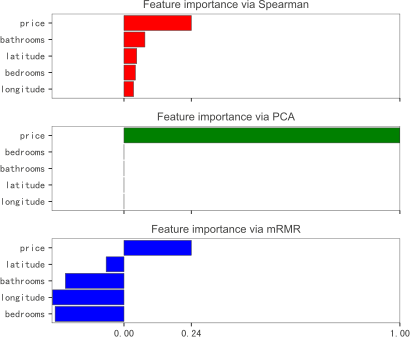

In [7]:
fig, ax = plt.subplots(3, 1, sharex=True, figsize=(6, 5))
plot_importances(I_cor,
                color='red',
                title='Feature importance via Spearman',
                imp_range=(-.025, 1.0),
                ax=ax[0])

plot_importances(I_pca,
                color='green',
                title='Feature importance via PCA',
                imp_range=(-.025, 1.0),
                ax=ax[1])

plot_importances(I_mrmr,
                color='blue',
                title='Feature importance via mRMR',
                imp_range=(-.025, 1.0),
                ax=ax[2])


## Model-based importance strategies

For model-based importance strategies, I use implementations from `rfpimp` library to get permutation importance and drop column importance for these features.

First, train a random forest model for the dataset.

In [8]:
X_train, X_test, y_train , y_test = train_test_split(X, y, test_size=0.15)

rf = RandomForestClassifier(n_estimators=100, min_samples_leaf=10, oob_score=True)
rf.fit(X_train, y_train)
rf.oob_score_

0.7151302772414122

Then I try permutation importance and drop column importance, using both $R^2$ score and accuracy score..

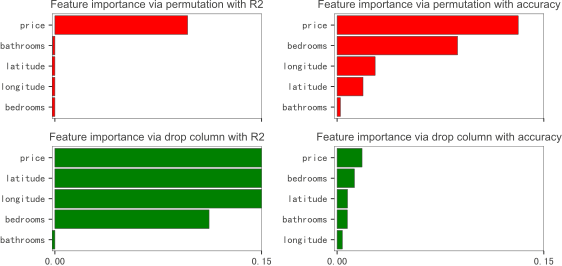

In [9]:
I_perm_r2 = permutation_importances(rf, X_test, y_test, oob_regression_r2_score)
I_perm_acc = permutation_importances(rf, X_test, y_test, oob_classifier_accuracy)
I_drop_r2 = dropcol_importances(rf, X_train, y_train, X_test, y_test, 
                                oob_regression_r2_score)
I_drop_acc = dropcol_importances(rf, X_train, y_train, X_test, y_test, 
                                oob_classifier_accuracy)

fig, ax = plt.subplots(2, 2, sharex=True, figsize=(8, 4))
plot_importances(I_perm_r2,
                color='red',
                title='Feature importance via permutation with R2',
                ax=ax[0][0])
plot_importances(I_perm_acc,
                color='red',
                title='Feature importance via permutation with accuracy',
                ax=ax[0][1])               
plot_importances(I_drop_r2,
                color='green',
                title='Feature importance via drop column with R2',
                ax=ax[1][0])
plot_importances(I_drop_acc,
                color='green',
                title='Feature importance via drop column with accuracy',
                ax=ax[1][1])

From the importance plots above, we can find that using different algorithms and metrics leads to very different results.

## Comparing strategies

For each mechanism to compute feature importances, I use OOB accuracy for evaluation. And I train random forest model on top k=1...5 features to see how good those features are. 

For model based importance strategies, I use accuracy as metric.

To make the plot more identifiable, I use interpolation for shap values.

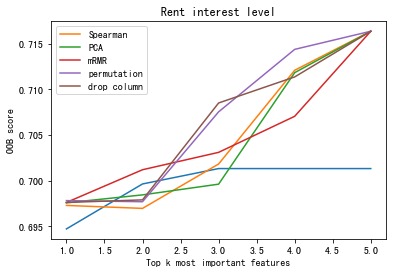

In [58]:
compare_strategies(X, y, I_cor, I_pca, I_mrmr, I_perm_acc, I_drop_acc)

+ We can find that the gap between OOB scores of model trained with only `price` feature and trained with all features is around 0.02, so the importance of `price` overwhelms the others.

+ The shap values indicates that the second most important feature also play a significant role in model prediction.

+ All methods except for mRMR don't gain improvement by top-1-feature to top-2-features model, indicate that these methods suffer from correlation between variables.

## Automatic feature selection algorithm

For each mechanism to compute feature importances, I train a random forest model and use OOB score for evaluation. In each step I drop the lowest importance feature and see whether the OOB score improves. For model based importance strategies, I use accuracy as metric.

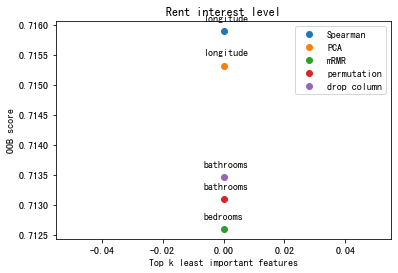

In [53]:
methods = ['Spearman', 'PCA', 'mRMR', 'permutation', 'drop column']
fig = plt.figure(figsize=(6, 4))
for method in methods:
    scores, dropped_features = select_feature(X, y, method)
    ks = list(range(len(scores)))
    plt.plot(ks, scores, 'o', label=method)
    for i, (a, b) in enumerate(zip(ks, scores)):
        plt.annotate(dropped_features[i], xy=(a, b), xytext=(-20,10),
                    textcoords='offset points')

plt.title("Rent interest level")
plt.xlabel("Top k least important features")
plt.ylabel("OOB score")
plt.legend()

From the plot above we can find that every mechanism only drop one feature, including `bathrooms`, `bedrooms` and `longtitude`. And all the mechanism yield similar best OOB accuracy.

## Variance and empirical p-values for feature importances

Here I first explore the variance of feature importance via Spearman's rank correlation coefficient by bootstraping, because it works very fast so is not so time-consuming in bootstraping.

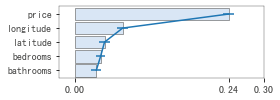

In [114]:
get_var(X, y, 1000)

The error bar here represent 3 standard deviations.

We can find that `latitude` varies the most while `bedrooms` varies the least. All of the features don't have high importance variances.

For p-value, I also explore the case using Spearman's rank correlation coefficient.

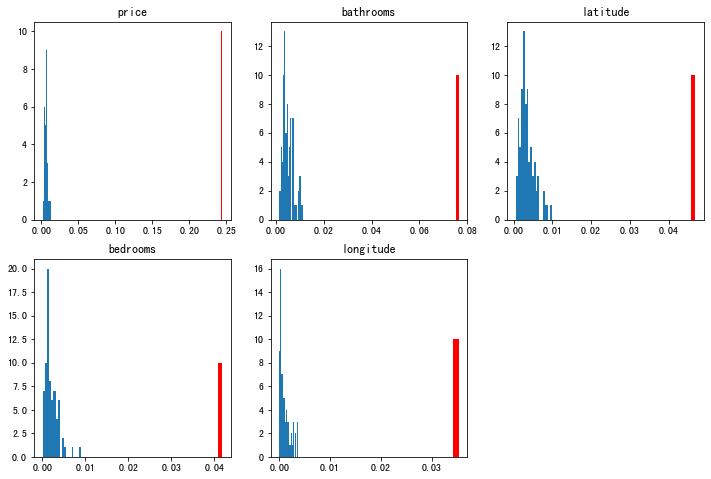

In [113]:
get_pvalue(X, y)

Alomost the whole null distibutions of the 5 feature importances are below their true importances, so their feature importances are significant.

## Conclusions

At the end of this project I can make the following conclusions:

+ Different mechanism for feature impotance lead to very different estimation of feature importances. But in this dataset `price` is always given a high importance;

+ The mRMR strategy works well to deal with codependencies;

+ For model-based importance strategies, different metrics result in very different esitimation of importances.

+ In this dataset, the `price` feature covers almost all pridictive performance, so other effort to drop or add features do little improve of model performance.

+ The variance and p-value of feature importances indicate that all features are significant and do not vary much.